In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import defaultdict

## Optimizing using GD and artificial data

In [2]:
def utility_function(risk_factor, portfolio_return):
    value = ((1 + portfolio_return)**(1-risk_factor))/(1-risk_factor)
    return value

In [3]:
def utility_function_grad(r_p, gamma, r_p_grad):
    u_grad = np.power((1+r_p),-gamma) * r_p_grad
    return u_grad

## Optimization formula:
## $\underset{\theta}{\max} \frac{1}{T} \sum^{T-1}_{t=0} u\left( \sum_{i=1}^{N_{t}}( \bar{w}_{i,t} + \frac{1}{N_{t}}\theta^{\text{T}} \hat{x}_{i,t} ) r_{i,t+1} \right) $

## Critical point of formula:

## $ \frac{1}{T} \sum^{T-1}_{t=0} u'(r_{p,t+1}) \frac{1}{N_{t}}\hat{x}_{t}^{\text{T}} r_{t+1} = 0 $


## Utility function

## $u(r_{p,t+1}) = \frac{(1+r_{p,t+1})^{1-\gamma}}{1-\gamma} $

## Portfolio return
## $ r_{p,t+1} = \sum^{N_{t}}_{i=1} \bar{w}_{i,t} r_{i,t+1} + \sum^{N_{t}}_{i=1} (  \frac{1}{N_{t}} \theta^{\text{T}} \hat{x}_{i,t} ) r_{i,t+1} $


## Utility function derivate

## $u'(r_{p,t+1}) = (1+r_{p, t+1})^{-\gamma} r'_{p, t+1} $

## Portfolio return derivate
## $ r'_{p,t+1} = \sum^{N_{t}}_{i=1} (  \frac{1}{N_{t}} \hat{x}_{i,t} ) r_{i,t+1} = \frac{1}{N_{t}}\hat{x}_{t}^{\text{T}} r_{t+1} $

## Critical point expanded:
## $ \frac{1}{T} \sum^{T-1}_{t=0} u'(r_{p,t+1}) \frac{1}{N_{t}}\hat{x}_{t}^{\text{T}} r_{t+1} = 0 $
## $ \frac{1}{T} \sum^{T-1}_{t=0} (1+r_{p, t+1})^{-\gamma} r'_{p, t+1} \frac{1}{N_{t}}\hat{x}_{t}^{\text{T}} r_{t+1} = 0 $
## $ \frac{1}{T} \sum^{T-1}_{t=0} (1+r_{p, t+1})^{-\gamma} (r'_{p, t+1})^2 $

In [10]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.5f}".format(x)})

time = 90 # 90 days
number_of_stocks = 10
np.random.seed(123)
r = np.empty(shape=(number_of_stocks,time))
gamma = 5
firm_characteristics = defaultdict(list)
# random initialization of theta for 3 firm characteristics
w = np.empty(shape=(number_of_stocks, time))
# Learning rate
lr = 1e-3
epochs = 5000
return_all = []

# Creating artificial return
for i in range(number_of_stocks):
    for t in range(time):
        # Toy firm characteristics
        if i>=5:
            # Negative return firms
            me = np.random.uniform(0,1)
            btm = np.random.uniform(-1,0)
            mom = np.random.uniform(-1,0)
        else:
            # Positive return firms
            me = np.random.uniform(-1,0)
            btm = np.random.uniform(0,1)
            mom = np.random.uniform(0,1)
#         me = np.random.uniform(-1,1)
#         btm = np.random.uniform(-1,1)
#         mom = np.random.uniform(-1,1)
            
        firm_characteristics[(i,'me')].append(me)
        firm_characteristics[(i,'btm')].append(btm)
        firm_characteristics[(i,'mom')].append(mom)
        # simplified weight using only firm characteristics
        # return of portifolio i at time t
        r[i][t] = (-0.337*me + 3.553*btm + 1.623*mom)

print("Created all artificial stocks")
firm_characteristics = pd.DataFrame(firm_characteristics)
# Normalize firm characteristics for each stock
firm_characteristics.T.loc[(slice(None), "me"), :] -= firm_characteristics.T.loc[(slice(None), "me"), :].mean()
firm_characteristics.T.loc[(slice(None), "btm"), :] -= firm_characteristics.T.loc[(slice(None), "btm"), :].mean()
firm_characteristics.T.loc[(slice(None), "mom"), :] -= firm_characteristics.T.loc[(slice(None), "mom"), :].mean()

Created all artificial stocks


In [11]:
# Creating a weight from a benchmark portifolio this one
# specific is related to return of each stock for simplicity
w_benchmark = np.empty(shape=(number_of_stocks, time))
epsilon=1e-5
for t in range(time):
    positive_returns = (r[:,t]-min(r[:,t]))+epsilon
    w_benchmark[:,t] = positive_returns/sum(positive_returns)

In [12]:
np.random.seed(123)
theta = np.random.rand(1, 3)
for k in tqdm(range(epochs)):
    r_p_grad=0
    r_p = 0
    # Optmize Theta over all stocks and times
#     print(f" Theta :{theta}, k:{k}")
    for i in range(number_of_stocks):
        firm_df = firm_characteristics[i].copy()
        firms_coeff = theta.dot(firm_df.T)
        # Multiply only t-1 firm characteristics
        # Starting return r at t+1
        r_p_grad += firm_df[:-1].T * r[i, 1:]
        r_p +=  w_benchmark[i,:-1]*r[i, 1:] + (1/number_of_stocks)*firms_coeff[:,:-1]*r[i, 1:]
    r_p_grad *= (1/number_of_stocks)
    u_grad = utility_function_grad(r_p, gamma, r_p_grad)
    # It will be changed with u_grad
    gradient = (r_p_grad * u_grad).T.sum()/time
#     print(f" Gradient :{gradient.to_numpy()}, k:{k}\n")
    theta += lr * gradient

    
    # Avaliate function
    for i in range(number_of_stocks):
        firm_df = firm_characteristics[i].copy()
        firms_coeff = theta.dot(firm_df.T)
        w[i] = w_benchmark[i] + (1/number_of_stocks)*firms_coeff
    
    # Using t-1 weights and r from 1 to t
    r_p = sum(w[:,:-1]*r[:,1:])
    utility_values = utility_function(5, r_p)
    # Average over T 
    average_return_portifolio = sum(utility_values)/len(utility_values)
    return_all.append(average_return_portifolio)
#     print(f"Return {average_return_portifolio}")
print(f"Finished running {epochs} epochs")


Finished running 5000 epochs


In [23]:
np.sum(w, axis=1)/time

array([0.16143, 0.16431, 0.16957, 0.15279, 0.15868, 0.04073, 0.04327,
       0.03851, 0.03118, 0.03953])

In [14]:
pd.DataFrame(return_all).describe()

,0
count,5000.000000
mean,-0.008991
std,0.000094
min,-0.009211
25%,-0.009060
50%,-0.008959
75%,-0.008906
max,-0.008897


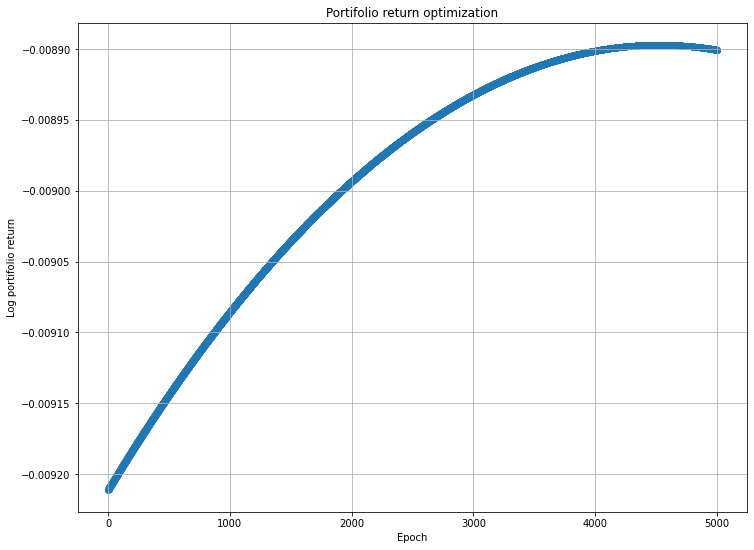

In [15]:
plt.figure(figsize=(12,9))
# plt.yscale('symlog')
plt.scatter(x=range(len(return_all)), y=return_all)
plt.title('Portifolio return optimization')
plt.ylabel('Log portifolio return')
plt.xlabel('Epoch')
plt.grid()
plt.show()

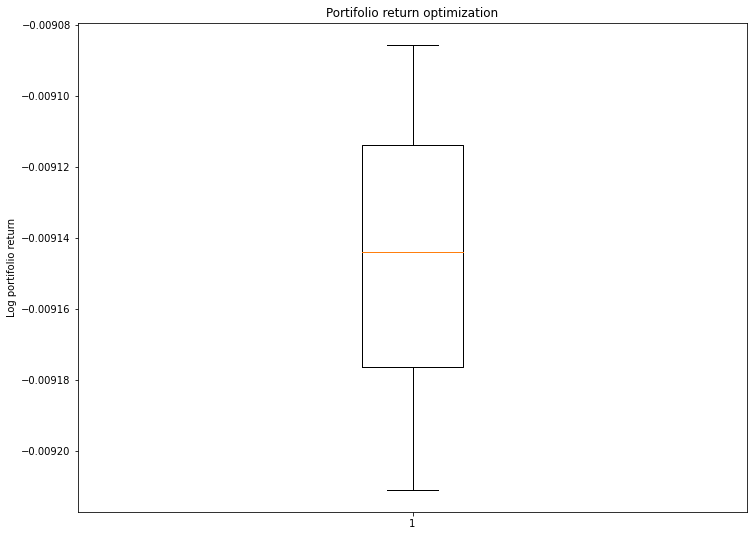

In [231]:
plt.figure(figsize=(12,9))
# plt.yscale('symlog')
plt.boxplot(return_all)
plt.title('Portifolio return optimization')
plt.ylabel('Log portifolio return')
plt.show()

## Using scipy to optimize easily and to add constraints

In [12]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.5f}".format(x)})

time = 90 # 4000 days
number_of_stocks = 10
np.random.seed(123)
r = np.empty(shape=(number_of_stocks,time))
gamma = 5
firm_characteristics = defaultdict(list)
# Learning rate
lr = 1e-3
epochs = 5000
return_all = []

# Creating artificial return
for i in range(number_of_stocks):
    for t in range(time):
        # Toy firm characteristics
        if i>=5:
            # Negative return firms
            me = np.random.uniform(0,1)
            btm = np.random.uniform(-1,0)
            mom = np.random.uniform(-1,0)
        else:
            # Positive return firms
            me = np.random.uniform(-1,0)
            btm = np.random.uniform(0,1)
            mom = np.random.uniform(0,1)
#         me = np.random.uniform(-1,1)
#         btm = np.random.uniform(-1,1)
#         mom = np.random.uniform(-1,1)
            
        firm_characteristics[(i,'me')].append(me)
        firm_characteristics[(i,'btm')].append(btm)
        firm_characteristics[(i,'mom')].append(mom)
        # simplified weight using only firm characteristics
        # return of portifolio i at time t
        r[i][t] = (-0.337*me + 3.553*btm + 1.623*mom)

print("Created all artificial stocks")
firm_characteristics = pd.DataFrame(firm_characteristics)
# Normalize firm characteristics for each stock
firm_characteristics.T.loc[(slice(None), "me"), :] -= firm_characteristics.T.loc[(slice(None), "me"), :].mean()
firm_characteristics.T.loc[(slice(None), "btm"), :] -= firm_characteristics.T.loc[(slice(None), "btm"), :].mean()
firm_characteristics.T.loc[(slice(None), "mom"), :] -= firm_characteristics.T.loc[(slice(None), "mom"), :].mean()

Created all artificial stocks


In [13]:
# Creating a weight from a benchmark portifolio this one
# specific is related to return of each stock for simplicity
w_benchmark = np.empty(shape=(number_of_stocks, time))
epsilon=1e-5
for t in range(time):
    positive_returns = (r[:,t]-min(r[:,t]))+epsilon
    w_benchmark[:,t] = positive_returns/sum(positive_returns)

In [14]:
def utility_function(risk_factor, portfolio_return):
    value = ((1 + portfolio_return)**(1-risk_factor))/(1-risk_factor)
    return value

In [52]:
time = 90
def objective(theta): 
    w = np.empty(shape=(number_of_stocks, time))
    for i in range(number_of_stocks):
        w[i] = w_benchmark[i] + (1/number_of_stocks)*theta.dot(firm_characteristics[i].copy().T)
    
    return -sum(sum(utility_function(5, w[:,:-1]*r[:,1:])))/time

In [48]:
np.random.seed(123)
theta0 = np.random.rand(1, 3)
theta0

array([[0.69647, 0.28614, 0.22685]])

In [17]:
from scipy.optimize import minimize

In [55]:
opt_iter = 1
mean_obj_r = []
mean_r = []
def callback_steps(thetaI):
    global opt_iter
    print(f"i:{opt_iter}, theta i: {thetaI}, f(theta):{objective(thetaI)}")
    mean_obj_r.append(-objective(thetaI))
    
    w_iter = np.empty(shape=(number_of_stocks, time))
    for i in range(number_of_stocks):
        w_iter[i] = w_benchmark[i] + (1/number_of_stocks)*thetaI.dot(firm_characteristics[i].copy().T)
    mean_r.append(sum(sum(w_iter*r)))
    
    opt_iter += 1

In [56]:
sol = minimize(objective, theta0, callback=callback_steps)
sol

i:1, theta i: [-0.06351 0.70841 0.74088], f(theta):1.2131658535421985
i:2, theta i: [-0.20432 0.90021 0.93178], f(theta):0.9978152325831017
i:3, theta i: [-0.52549 1.36168 1.38148], f(theta):0.6731738839743524
i:4, theta i: [-0.91579 1.94000 1.93716], f(theta):0.451484515895554
i:5, theta i: [-1.39522 2.65933 2.62362], f(theta):0.3002525460209777
i:6, theta i: [-1.98102 3.54260 3.46382], f(theta):0.1983528425988593
i:7, theta i: [-2.69483 4.62088 4.48809], f(theta):0.1301370450768914
i:8, theta i: [-3.56019 5.92892 5.72992], f(theta):0.08483774706203423
i:9, theta i: [-4.60438 7.50756 7.22839], f(theta):0.054968658415998156
i:10, theta i: [-5.85825 9.40331 9.02778], f(theta):0.03541244184901504
i:11, theta i: [-7.35715 11.66955 11.17886], f(theta):0.022691391987925764
i:12, theta i: [-9.14152 14.36743 13.73968], f(theta):0.014466088600210095
i:13, theta i: [-11.25767 17.56695 16.77670], f(theta):0.009176830512822358
i:14, theta i: [-13.75844 21.34802 20.36577], f(theta):0.0057930025887

      fun: 0.00033151769537402044
 hess_inv: array([[141944.34195, -214613.46502, -203717.71370],
       [-214613.46502, 324488.78434, 308013.86671],
       [-203717.71370, 308013.86671, 292377.30351]])
      jac: array([0.00001, -0.00000, -0.00001])
  message: 'Optimization terminated successfully.'
     nfev: 84
      nit: 20
     njev: 21
   status: 0
  success: True
        x: array([-40.71603, 62.10689, 59.05532])

In [20]:
sol_theta = sol.x
w_sol = np.empty(shape=(number_of_stocks, time))
for i in range(number_of_stocks):
    firm_df = firm_characteristics[i].copy()
    firms_coeff = sol_theta.dot(firm_df.T)
    w_sol[i] = w_benchmark[i] + (1/number_of_stocks)*firms_coeff

In [28]:
np.sum(w_sol, axis=1)/time

array([8.31961, 8.38071, 8.25111, 7.94663, 8.36792, -8.06084, -7.75736,
       -8.13767, -8.13713, -8.17299])

In [44]:
sum(sum(w_benchmark*r))

190.9346282688151

In [45]:
sum(sum(w_sol*r))

22450.27196617353

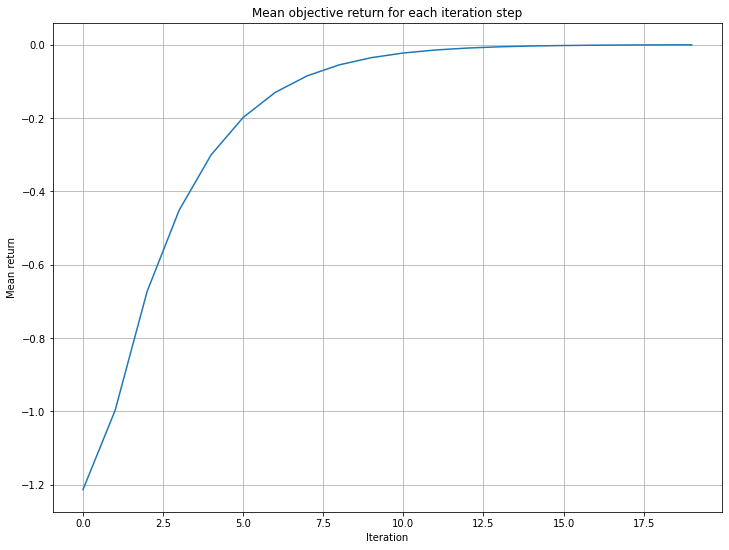

In [68]:
x = range(len(mean_obj_r))
plt.figure(figsize=(12,9))
plt.title("Mean objective return for each iteration step")
plt.plot(x, mean_obj_r)
plt.xlabel('Iteration')
plt.ylabel('Mean return')
plt.grid()
plt.show()

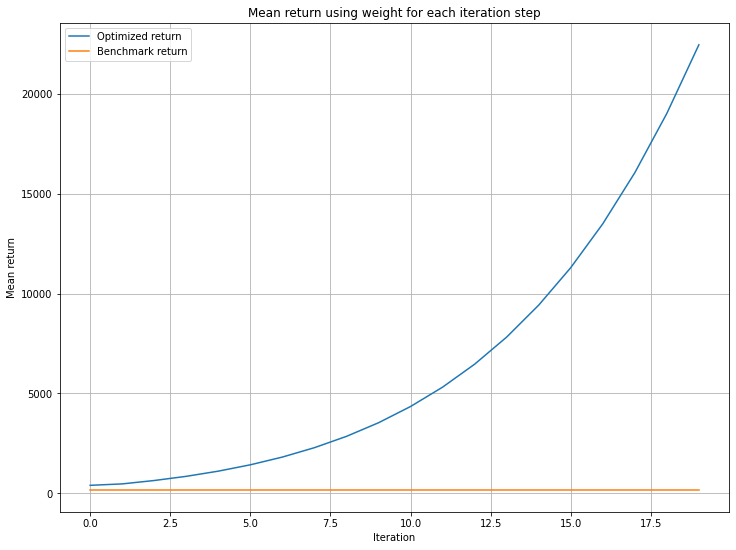

In [70]:
x = range(len(mean_r))
plt.figure(figsize=(12,9))
plt.title("Mean return using weight for each iteration step")
plt.plot(x, mean_r, label='Optimized return')
plt.plot(x, [sum(sum(w_benchmark*r))]*len(x), label='Benchmark return')
plt.xlabel('Iteration')
plt.ylabel('Mean return')
plt.legend()
plt.grid()
plt.show()

## Using real data

### Training

In [123]:
lreturn = pd.read_csv('monthly_lagged_return.csv')
mcap = pd.read_csv('monthly_market_cap.csv')
book_to_mkt_ratio = pd.read_csv('monthly_book_to_mkt_ratio.csv')
monthly_return = pd.read_csv('monthly_return.csv')
lreturn.fillna(method='bfill', inplace=True)
mcap.fillna(method='bfill', inplace=True)
book_to_mkt_ratio.fillna(method='bfill', inplace=True)
monthly_return.fillna(method='bfill', inplace=True)

In [124]:
from sklearn.model_selection import TimeSeriesSplit
splits = TimeSeriesSplit(n_splits=3)

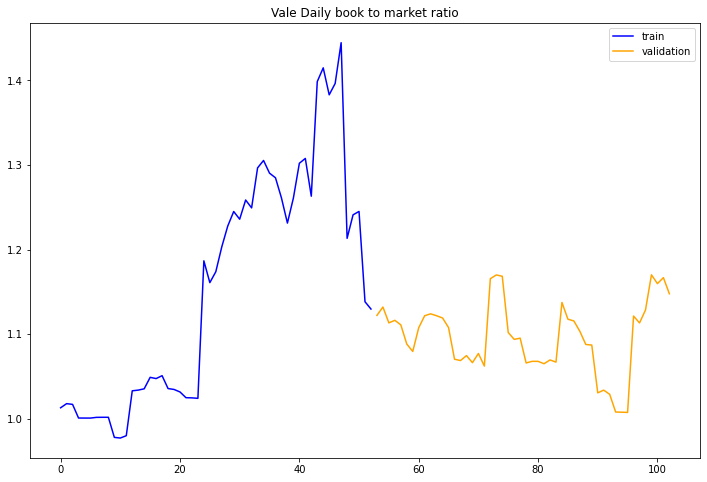

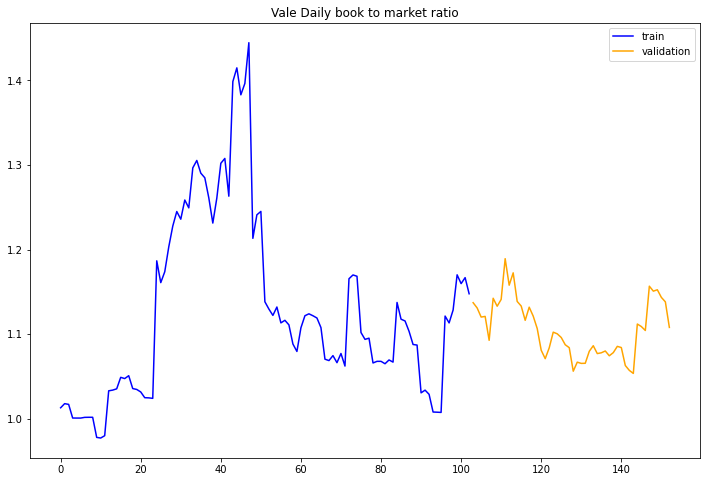

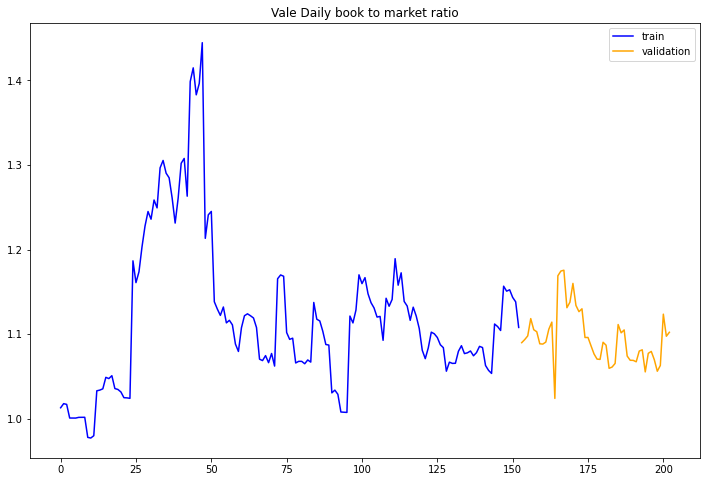

In [125]:
for train, val in splits.split(book_to_mkt_ratio):
    train_btm = book_to_mkt_ratio.loc[train]
    train_me = mcap.loc[train]
    train_mom = lreturn.loc[train]
    train_return = monthly_return.loc[train]
    
    val_btm = book_to_mkt_ratio.loc[val]
    val_me = mcap.loc[val]
    val_mom = lreturn.loc[val]
    
    test_return = monthly_return.loc[val]

    plt.figure(figsize=(12,8))
    plt.title("Vale Daily book to market ratio")
    plt.ticklabel_format(style='plain')
    train_btm['VALE3'].plot(c='blue', label='train')
    val_btm['VALE3'].plot(c='orange', label='validation')
    plt.legend()
    # plt.grid()
    plt.show()

In [5]:
list(train_me.columns)

['ABCB4',
 'ABRE11',
 'AEDU3',
 'AELP3',
 'AGEN11',
 'AGRO3',
 'ALLL3',
 'ALPA4',
 'ALSC3',
 'AMAR3',
 'AMBV3',
 'AMBV4',
 'AMIL3',
 'ARZZ3',
 'AUTM3',
 'BAZA3',
 'BBAS3',
 'BBDC3',
 'BBDC4',
 'BBRK3',
 'BEEF3',
 'BEMA3',
 'BHGR3',
 'BICB4',
 'BISA3',
 'BOBR4',
 'BPHA3',
 'BPNM4',
 'BRAP4',
 'BRFS3',
 'BRIN3',
 'BRKM5',
 'BRML3',
 'BRPR3',
 'BRSR6',
 'BRTO3',
 'BRTO4',
 'BTOW3',
 'BTTL4',
 'BVMF3',
 'CARD3',
 'CCIM3',
 'CCPR3',
 'CCRO3',
 'CESP6',
 'CGAS3',
 'CGAS5',
 'CIEL3',
 'CLSC6',
 'CMIG3',
 'CMIG4',
 'CNFB4',
 'COCE3',
 'COCE5',
 'CPFE3',
 'CPLE3',
 'CPLE6',
 'CRDE3',
 'CREM3',
 'CRUZ3',
 'CSAN3',
 'CSMG3',
 'CSNA3',
 'CTAX3',
 'CTAX4',
 'CTIP3',
 'CTNM4',
 'CYRE3',
 'CZLT11',
 'CZRS4',
 'DAGB11',
 'DASA3',
 'DAYC4',
 'DIRR3',
 'DROG3',
 'DTEX3',
 'ECOR3',
 'ELET3',
 'ELET6',
 'ELPL4',
 'EMBR3',
 'ENBR3',
 'EQTL3',
 'ESTC3',
 'ESTR4',
 'ETER3',
 'EUCA4',
 'EVEN3',
 'EZTC3',
 'FESA4',
 'FFTL4',
 'FHER3',
 'FIBR3',
 'FJTA4',
 'FLRY3',
 'FRAS4',
 'FRIO3',
 'FTRX4',
 'GETI3',
 'GETI

In [126]:
def create_characteristics(me_df, mom_df, btm_df, return_df):
    firm_characteristics = defaultdict(list)

    stocks_names = list(return_df.columns)

    time = return_df.shape[0] 
    number_of_stocks = len(stocks_names)
    r = np.empty(shape=(number_of_stocks, time))
    epsilon = 1e-10

    for i, name in enumerate(stocks_names):
        me = me_df.get(name)
        mom = mom_df.get(name)
        btm = btm_df.get(name)
        mr = return_df.get(name) 

        firm_characteristics[(i,'me')] = me.fillna(method='bfill')
        firm_characteristics[(i,'btm')] = btm.fillna(method='bfill')
        firm_characteristics[(i,'mom')]= mom.fillna(method='bfill')

        r[i] = mr.fillna(method='bfill')

    print("Created firm characteristics matrix")
    firm_characteristics = pd.DataFrame(firm_characteristics)
    #Normalize firm characteristics for each stock
    sum_df = firm_characteristics.T.loc[(slice(None), "me"), :].sum()
    firm_characteristics.T.loc[(slice(None), "me"), :] -= firm_characteristics.T.loc[(slice(None), "me"), :].mean()
    firm_characteristics.T.loc[(slice(None), "me"), :] /= (sum_df + epsilon)

    sum_df = firm_characteristics.T.loc[(slice(None), "btm"), :].sum()
    firm_characteristics.T.loc[(slice(None), "btm"), :] -= firm_characteristics.T.loc[(slice(None), "btm"), :].mean()
    firm_characteristics.T.loc[(slice(None), "btm"), :] /= (sum_df + epsilon)


    sum_df = firm_characteristics.T.loc[(slice(None), "mom"), :].sum()
    firm_characteristics.T.loc[(slice(None), "mom"), :] -= firm_characteristics.T.loc[(slice(None), "mom"), :].mean()
    firm_characteristics.T.loc[(slice(None), "mom"), :] /= (sum_df + epsilon)

    print("Normalized firm characteristics")
    return firm_characteristics, r, time, number_of_stocks

In [127]:
firm_characteristics, r, time, number_of_stocks = create_characteristics(train_me, train_mom, train_btm, train_return)

Created firm characteristics matrix
Normalized firm characteristics


In [128]:
# Creating a weight from a benchmark portifolio this one
# specific is related to return of each stock for simplicity
w_benchmark = np.empty(shape=(number_of_stocks, time))
epsilon=1e-5
for t in range(time):
    positive_returns = (r[:,t]-min(r[:,t]))+epsilon
    w_benchmark[:,t] = positive_returns/sum(positive_returns)

In [129]:
def utility_function(risk_factor, portfolio_return):
    value = ((1 + portfolio_return)**(1-risk_factor))/(1-risk_factor)
    return value

In [130]:
def objective(theta): 
    w = np.empty(shape=(number_of_stocks, time))
    for i in range(number_of_stocks):
        w[i] = w_benchmark[i].copy() + (1/number_of_stocks)*theta.dot(firm_characteristics[i].copy().T)
    return -sum(sum(utility_function(5, w[:,:-1]*r[:,1:])))/time

In [131]:
def constraint(theta):
    w_sol = np.empty(shape=(number_of_stocks, time))
    for i in range(number_of_stocks):
        firm_df = firm_characteristics[i].copy()
        firms_coeff = sol_theta.dot(firm_df.T)
        w_sol[i] = w_benchmark[i] + (1/number_of_stocks)*firms_coeff
    mean_w = np.sum(w_sol, axis=1)/time
    return mean_w

cons = [{"type" : "ineq", "fun" : constraint}]

In [132]:
np.random.seed(123)
theta0 = np.random.rand(1, 3)
theta0

array([[0.69646919, 0.28613933, 0.22685145]])

In [133]:
from scipy.optimize import minimize, differential_evolution

In [134]:
opt_iter = 1
mean_obj_r = []
mean_r = []
def callback_steps(thetaI):
    global opt_iter
    print(f"i:{opt_iter}, theta i: {thetaI}, f(theta):{objective(thetaI)}")
    mean_obj_r.append(-objective(thetaI))
    
    w_iter = np.empty(shape=(number_of_stocks, time))
    for i in range(number_of_stocks):
        w_iter[i] = w_benchmark[i] + (1/number_of_stocks)*thetaI.dot(firm_characteristics[i].copy().T)
    mean_r.append(sum(sum(w_iter*r)))
    
    opt_iter += 1

In [135]:
# sol = minimize(objective, theta0, callback=callback_steps, method='COBYLA', constraints=cons)
sol = minimize(objective, theta0, callback=callback_steps, method='BFGS')
sol

i:1, theta i: [0.69618323 0.2886935  0.31614189], f(theta):181.03542713751835
i:2, theta i: [0.67736826 0.25185727 0.52803636], f(theta):127.62398205493312
i:3, theta i: [0.69443264 0.10005443 0.55165369], f(theta):122.81787424224102
i:4, theta i: [0.57567692 0.94252251 0.57336131], f(theta):115.8036831318571
i:5, theta i: [0.24961395 3.06399383 0.61717082], f(theta):105.70995388751548
i:6, theta i: [0.07360409 3.71240807 0.62562889], f(theta):104.88742883190741
i:7, theta i: [-0.22902986  3.97374322  0.62157191], f(theta):104.68625047726432
i:8, theta i: [-0.70651314  3.96102873  0.61892741], f(theta):104.54098227179031
i:9, theta i: [-1.75863062  3.96210629  0.61621145], f(theta):104.26586290176039
i:10, theta i: [-3.87904957  3.94741117  0.61264304], f(theta):103.74050747498684
i:11, theta i: [-8.17460704  3.91487407  0.60726543], f(theta):102.74396004786267
i:12, theta i: [-17.00029711   3.83940788   0.59826016], f(theta):100.88986934583053
i:13, theta i: [-35.6584423    3.67159042

      fun: 91.25618374576743
 hess_inv: array([[ 4.14309271e+01,  4.34977139e-01,  1.68430798e-02],
       [ 4.34977139e-01,  6.45372384e-01, -3.99520060e-04],
       [ 1.68430798e-02, -3.99520060e-04,  2.77653529e-04]])
      jac: array([3.81469727e-06, 2.86102295e-06, 2.86102295e-06])
  message: 'Optimization terminated successfully.'
     nfev: 144
      nit: 25
     njev: 36
   status: 0
  success: True
        x: array([-84.09840519,   3.05067383,   0.58774566])

In [136]:
sol_theta = sol.x
w_sol = np.empty(shape=(number_of_stocks, time))
for i in range(number_of_stocks):
    firm_df = firm_characteristics[i].copy()
    firms_coeff = sol_theta.dot(firm_df.T)
    w_sol[i] = w_benchmark[i] + (1/number_of_stocks)*firms_coeff

In [137]:
np.sum(w_sol, axis=1)/time

array([ 0.00436552,  0.0027281 ,  0.00322151,  0.0055158 ,  0.0021842 ,
        0.00613351,  0.00561986,  0.00516737,  0.00586523,  0.00341944,
       -0.00053283, -0.0005291 ,  0.00217028,  0.00487269,  0.00524486,
        0.00544615,  0.00147847, -0.0008167 , -0.0007795 ,  0.00478217,
        0.00432884,  0.00669177,  0.00417621,  0.00342564,  0.00468847,
        0.00505634,  0.00362167,  0.00380935,  0.00444922,  0.00491534,
        0.00653271,  0.00448919,  0.00761356,  0.00409062,  0.00456997,
        0.00377474,  0.00384371,  0.00293098,  0.01050303, -0.00763802,
        0.00346805,  0.00317082,  0.00442593,  0.00421313,  0.00502243,
        0.00563064,  0.00493686, -0.00348482,  0.00505904,  0.00315701,
        0.00314581,  0.00524759,  0.00516366,  0.00514462,  0.00214597,
        0.00394863,  0.00393285,  0.00387774,  0.00626732,  0.00367512,
        0.00480333,  0.00368053,  0.00343025,  0.00622903,  0.00434082,
        0.00463286,  0.004968  ,  0.00751294,  0.00408944,  0.00

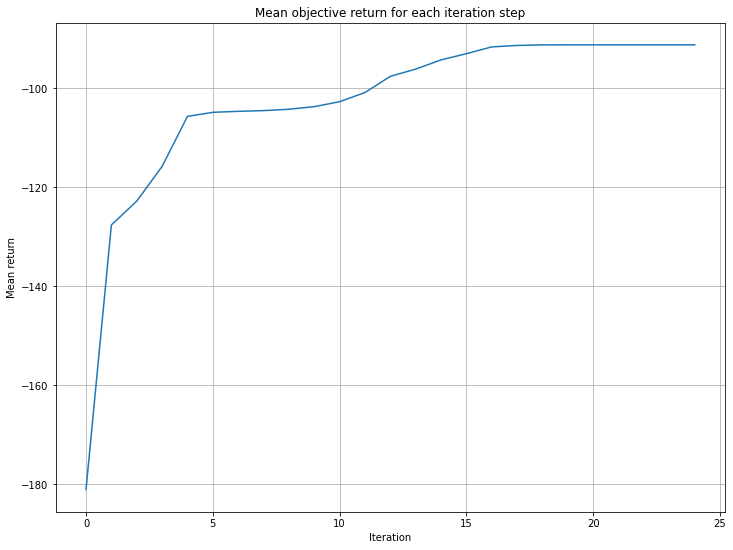

In [138]:
x = range(len(mean_obj_r))
plt.figure(figsize=(12,9))
plt.title("Mean objective return for each iteration step")
plt.plot(x, mean_obj_r)
plt.xlabel('Iteration')
plt.ylabel('Mean return')
plt.ticklabel_format(style='plain')
plt.grid()
plt.show()

In [139]:
benchmark_mean_return = sum(sum(w_benchmark*r))

# Equally diveded weights for each stock
uniform_weighted_stocks = np.ones_like(w_benchmark)*(1/number_of_stocks)
uniform_weighted_return = sum(sum(uniform_weighted_stocks*r))

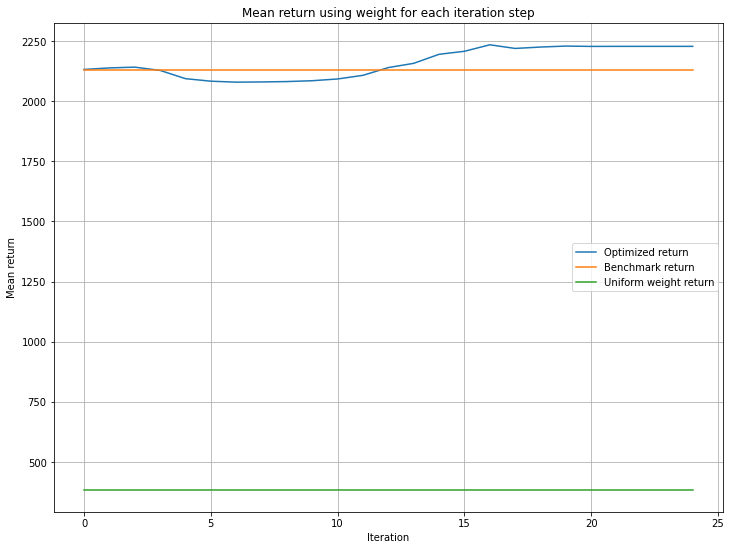

In [140]:
x = range(len(mean_r))
plt.figure(figsize=(12,9))
plt.title("Mean return using weight for each iteration step")
plt.plot(x, mean_r, label='Optimized return')
plt.plot(x, [benchmark_mean_return]*len(x), label='Benchmark return')
plt.plot(x, [uniform_weighted_return]*len(x), label='Uniform weight return')
plt.xlabel('Iteration')
plt.ylabel('Mean return')
plt.legend()
plt.grid()
plt.show()

### Testing

In [141]:
sol_theta = sol.x
firm_characteristics_val, r_val, time_val, number_of_stocks = create_characteristics(val_me, val_mom, val_btm, test_return)
firm_characteristics_val.fillna(method='ffill', inplace=True)

#### CREATE BENCHMARK FOR TESTING
w_benchmark_val = np.empty(shape=(number_of_stocks, time_val))
epsilon=1e-5
for t in range(time_val):
    positive_returns = (r_val[:,t]-min(r_val[:,t]))+epsilon
    w_benchmark_val[:,t] = positive_returns/sum(positive_returns)
    
w_val = np.empty(shape=(number_of_stocks, time_val))

for i in range(number_of_stocks):
    firm_df = firm_characteristics_val[i].copy()
    firms_coeff = sol_theta.dot(firm_df.T)
    w_val[i] = w_benchmark_val[i] + (1/number_of_stocks)*firms_coeff

Created firm characteristics matrix
Normalized firm characteristics


In [142]:
benchmark_mean_return = sum(sum(w_benchmark_val*r_val))
benchmark_mean_return

381.18393749693354

In [143]:
mean_return = sum(sum(w_val*r_val))
mean_return

386.4309169605893

### Testing and optimizing

In [92]:
sol_theta = sol.x
w_sol = np.empty(shape=(number_of_stocks, time))
for i in range(number_of_stocks):
    firm_df = firm_characteristics[i].copy()
    firms_coeff = sol_theta.dot(firm_df.T)
    w_sol[i] = w_benchmark[i] + (1/number_of_stocks)*firms_coeff

In [94]:
sum(np.sum(w_sol, axis=1)/time)

0.9999999999996554

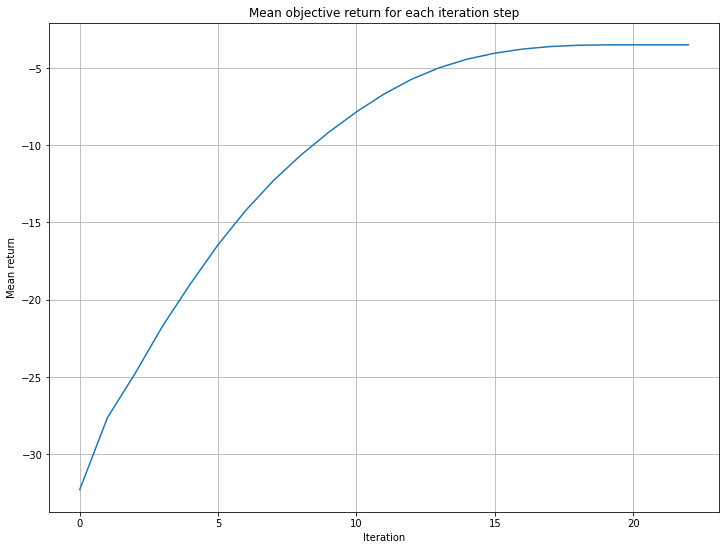

In [95]:
x = range(len(mean_obj_r))
plt.figure(figsize=(12,9))
plt.title("Mean objective return for each iteration step")
plt.plot(x, mean_obj_r)
plt.xlabel('Iteration')
plt.ylabel('Mean return')
plt.ticklabel_format(style='plain')
plt.grid()
plt.show()

In [97]:
benchmark_mean_return = sum(sum(w_benchmark*r))

# Equally diveded weights for each stock
uniform_weighted_stocks = np.ones_like(w_benchmark)*(1/number_of_stocks)
uniform_weighted_return = sum(sum(uniform_weighted_stocks*r))

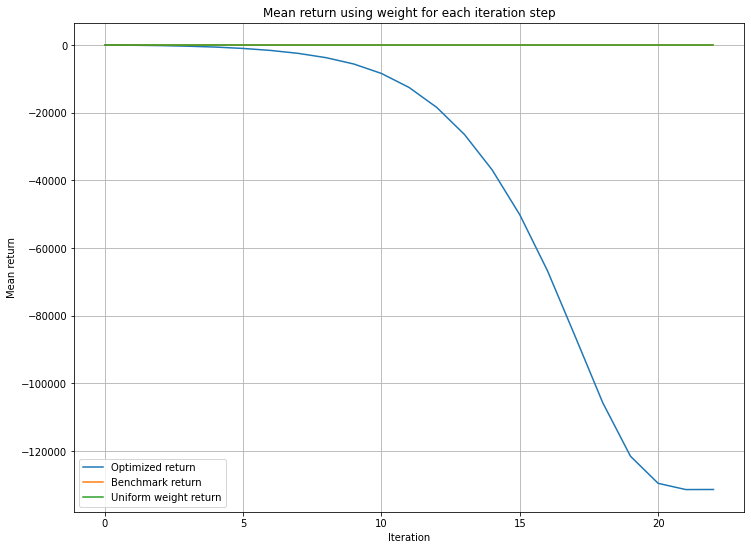

In [98]:
x = range(len(mean_r))
plt.figure(figsize=(12,9))
plt.title("Mean return using weight for each iteration step")
plt.plot(x, mean_r, label='Optimized return')
plt.plot(x, [benchmark_mean_return]*len(x), label='Benchmark return')
plt.plot(x, [uniform_weighted_return]*len(x), label='Uniform weight return')
plt.xlabel('Iteration')
plt.ylabel('Mean return')
plt.legend()
plt.grid()
plt.show()

In [144]:
# For each tuple try previous theta and try to optmize
mean_obj_r_tuple = []
mean_r_tuple = []
bench_tuple = []
eq_weighted_tuple = []
return_tuple = []

for i in range(0, test_return.shape[0], 2):
    firm_characteristics_val, r_val, time_val, number_of_stocks = create_characteristics(val_me.iloc[i:i+2], val_mom.iloc[i:i+2], val_btm.iloc[i:i+2], test_return.iloc[i:i+2])
    firm_characteristics_val.fillna(method='ffill', inplace=True)
    
    sol_theta = sol.x
    theta0 = sol_theta
    firm_characteristics = firm_characteristics_val
    r = r_val
    time = time_val

    w_benchmark = np.empty(shape=(number_of_stocks, time))
    epsilon=1e-5
    for t in range(time):
        positive_returns = (r[:,t]-min(r[:,t]))+epsilon
        w_benchmark[:,t] = positive_returns/sum(positive_returns)
    
    opt_iter = 1
    mean_obj_r = []
    mean_r = []
    sol = minimize(objective, theta0, callback=callback_steps, method='BFGS')
    mean_obj_r_tuple.append(mean_obj_r)
    mean_r_tuple.append(mean_r)
    
    
    benchmark_mean_return = sum(sum(w_benchmark*r))
    bench_tuple.append(benchmark_mean_return)
    
    # Equally diveded weights for each stock
    uniform_weighted_stocks = np.ones_like(w_benchmark)*(1/number_of_stocks)
    uniform_weighted_return = sum(sum(uniform_weighted_stocks*r))
    eq_weighted_tuple.append(uniform_weighted_return)
    
    sol_theta = sol.x
    w_sol = np.empty(shape=(number_of_stocks, time))
    for i in range(number_of_stocks):
        firm_df = firm_characteristics[i].copy()
        firms_coeff = sol_theta.dot(firm_df.T)
        w_sol[i] = w_benchmark[i] + (1/number_of_stocks)*firms_coeff
    
    return_tuple.append(sum(sum(w_sol*r)))
    

Created firm characteristics matrix
Normalized firm characteristics
i:1, theta i: [-83.81633265   3.08145557  -7.6132865 ], f(theta):32.29670300267634
i:2, theta i: [-83.1227851    3.15723658 -27.93866206], f(theta):27.644127591297295
i:3, theta i: [-82.38243268   3.2383676  -49.63512763], f(theta):24.780533304768994
i:4, theta i: [-81.08058064   3.38122949 -87.79842664], f(theta):21.689592483010074
i:5, theta i: [ -79.18195282    3.58971725 -143.47223628], f(theta):18.97704619254287
i:6, theta i: [ -76.23670215    3.9132508  -229.85414032], f(theta):16.442163771758835
i:7, theta i: [ -71.8994728     4.38981595 -357.07825958], f(theta):14.220080130353688
i:8, theta i: [ -65.55870949    5.08665809 -543.08546154], f(theta):12.293418279627058
i:9, theta i: [ -56.33947512    6.09996936 -813.54313532], f(theta):10.62943994571219
i:10, theta i: [  -42.72240296     7.5967721  -1213.02425001], f(theta):9.1606090872453
i:11, theta i: [  -22.34463042     9.83680986 -1810.84831788], f(theta):7.84

i:36, theta i: [   901.91433317   1142.88473035 -23894.58491564], f(theta):77.84674601938757
i:37, theta i: [   900.36125993   1150.33787777 -23890.36869333], f(theta):77.84142960260355
i:38, theta i: [   898.08289574   1162.71550347 -23883.15048577], f(theta):77.83204275162377
i:39, theta i: [   894.81473744   1181.83226163 -23871.48682104], f(theta):77.81606365249662
i:40, theta i: [   890.57730977   1210.10846789 -23853.28868882], f(theta):77.78951530280197
i:41, theta i: [   885.84352539   1248.14774818 -23827.05549949], f(theta):77.74448073386017
i:42, theta i: [   880.95463698   1296.76117876 -23790.52621529], f(theta):77.665121707788
i:43, theta i: [   875.6953398    1359.13140972 -23738.40077062], f(theta):77.52116232831646
i:44, theta i: [   869.63168102   1444.2410195  -23658.78807264], f(theta):77.25709245669819
i:45, theta i: [   862.09508059   1565.77717287 -23530.59252929], f(theta):76.77387780948155
i:46, theta i: [   852.21252807   1743.31949553 -23316.94906067], f(thet

i:12, theta i: [   415.63278825 -19078.40325463  -5831.33991312], f(theta):92.23497384588298
i:13, theta i: [   416.8233729  -19077.79380582  -5833.08514141], f(theta):92.2276987840848
i:14, theta i: [   418.28699259 -19077.11312136  -5835.34842447], f(theta):92.2139440980481
i:15, theta i: [   420.25209312 -19076.31170522  -5838.58048596], f(theta):92.18785432984974
i:16, theta i: [   423.10674357 -19075.33136587  -5843.59159551], f(theta):92.13897665440548
i:17, theta i: [   427.35306425 -19074.21349489  -5851.63056811], f(theta):92.04873596692963
i:18, theta i: [   433.80763538 -19073.14648296  -5864.93647197], f(theta):91.88677760066643
i:19, theta i: [   443.5362744  -19072.79815436  -5887.15690053], f(theta):91.60714743753968
i:20, theta i: [   457.54394566 -19074.9408472   -5923.69454757], f(theta):91.1438536364093
i:21, theta i: [   475.77732273 -19083.34737934  -5980.90765351], f(theta):90.3945505905183
i:22, theta i: [   496.01480087 -19104.32290905  -6064.42019683], f(theta)

i:15, theta i: [  1749.33987007 -16179.21608273  -6461.8220144 ], f(theta):45470.86529076499
i:16, theta i: [  1766.02909327 -16153.22236225  -6453.03601861], f(theta):44311.499892467364
i:17, theta i: [  1773.80182089 -16112.77373213  -6444.07966419], f(theta):42233.82258703611
i:18, theta i: [  1772.15687423 -16107.46372535  -6432.01039945], f(theta):38579.782498575245
i:19, theta i: [  1728.6328171  -16101.79836763  -6421.90727732], f(theta):32262.01765983305
i:20, theta i: [  1603.11997739 -16176.09054681  -6412.12245211], f(theta):22286.563614723756
i:21, theta i: [  1389.89077113 -16322.6715644   -6405.64802344], f(theta):13319.263056051434
i:22, theta i: [  1159.71548057 -16487.35005008  -6401.2881517 ], f(theta):8268.94008059751
i:23, theta i: [   886.88620822 -16684.89014829  -6397.04123989], f(theta):5074.0834684274605
i:24, theta i: [   582.5680775  -16906.38827833  -6392.71119564], f(theta):3209.6401430726196
i:25, theta i: [   265.2509127  -17138.30316206  -6388.37511771],

i:12, theta i: [6145102.87778176 6381609.94897161 1954842.86706127], f(theta):1.0527822198564358
i:13, theta i: [6145017.11117556 6381602.13717659 1955147.00697775], f(theta):0.8330125684718562
i:14, theta i: [6144921.91016542 6381593.46610038 1955484.60265059], f(theta):0.7029254333479865
i:15, theta i: [6144809.84646767 6381583.25914208 1955881.99564586], f(theta):0.6215686229802594
i:16, theta i: [6144685.91418689 6381571.97116514 1956321.47623819], f(theta):0.5739737705470564
i:17, theta i: [6144542.16422823 6381558.87816254 1956831.2329766 ], f(theta):0.5446947268173705
i:18, theta i: [6144376.42562696 6381543.78239497 1957418.96441654], f(theta):0.5269911746288333
i:19, theta i: [6144201.58891641 6381527.85795545 1958038.95897467], f(theta):0.5170340849383923
i:20, theta i: [6143994.28643762 6381508.97647581 1958774.08152814], f(theta):0.5106743337715296
Created firm characteristics matrix
Normalized firm characteristics
i:1, theta i: [6143770.28643845 6381342.30980976 1960114.08

In [146]:
x = range(len(return_tuple))

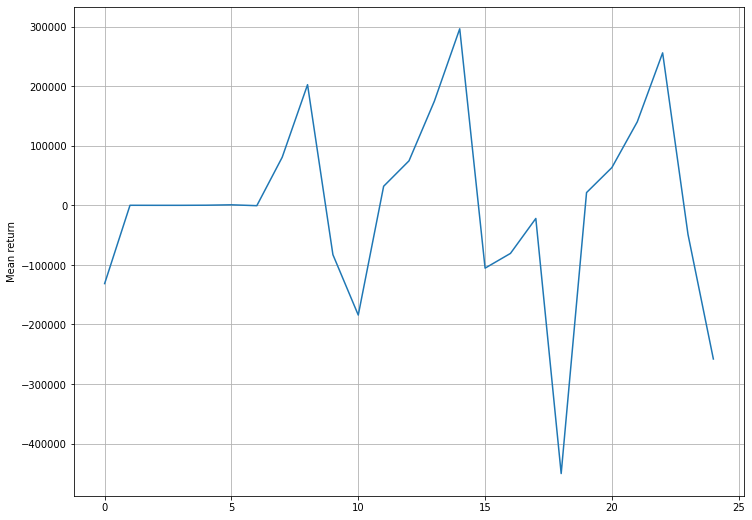

In [149]:
x = range(len(return_tuple))
plt.figure(figsize=(12,9))
plt.plot(x,return_tuple)
# plt.xlabel('Iteration')
plt.ylabel('Mean return')
# plt.legend()
plt.grid()
plt.show()

In [151]:
sum(return_tuple)/len(return_tuple)

-814.2736236383219

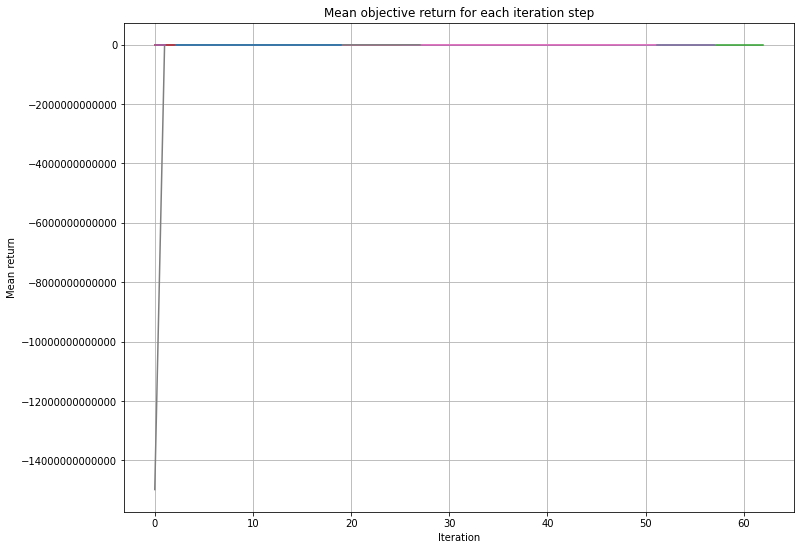

In [157]:
plt.figure(figsize=(12,9))
plt.title("Mean objective return for each iteration step")
for mean_obj_r in mean_obj_r_tuple:
    x = range(len(mean_obj_r))
    plt.plot(x, mean_obj_r)

plt.xlabel('Iteration')
plt.ylabel('Mean return')
plt.ticklabel_format(style='plain')
plt.grid()
plt.show()

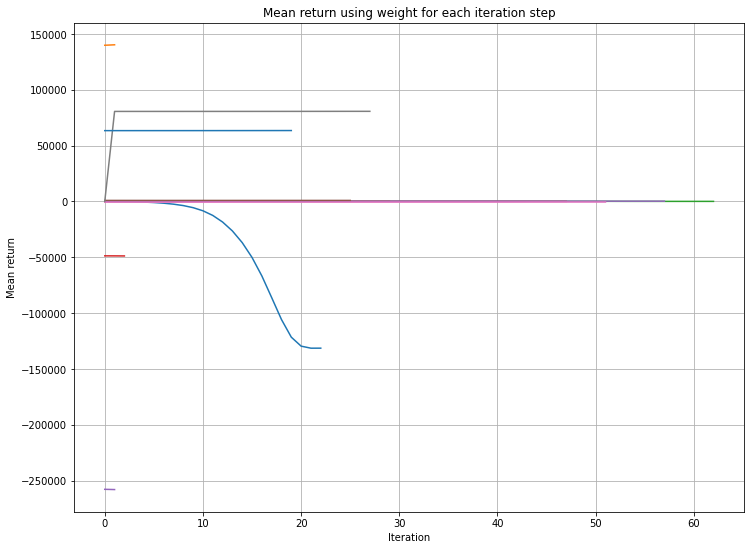

In [158]:
plt.figure(figsize=(12,9))
plt.title("Mean return using weight for each iteration step")
for mean_r in mean_r_tuple:
    x = range(len(mean_r))
    plt.plot(x, mean_r)

plt.xlabel('Iteration')
plt.ylabel('Mean return')
plt.ticklabel_format(style='plain')
plt.grid()
plt.show()

## Training with k-fold (k=10)

In [159]:
lreturn = pd.read_csv('monthly_lagged_return.csv')
mcap = pd.read_csv('monthly_market_cap.csv')
book_to_mkt_ratio = pd.read_csv('monthly_book_to_mkt_ratio.csv')
monthly_return = pd.read_csv('monthly_return.csv')
lreturn.fillna(method='bfill', inplace=True)
mcap.fillna(method='bfill', inplace=True)
book_to_mkt_ratio.fillna(method='bfill', inplace=True)
monthly_return.fillna(method='bfill', inplace=True)

In [160]:
from sklearn.model_selection import TimeSeriesSplit
splits = TimeSeriesSplit(n_splits=10)

In [161]:
def create_characteristics(me_df, mom_df, btm_df, return_df):
    firm_characteristics = defaultdict(list)

    stocks_names = list(return_df.columns)

    time = return_df.shape[0] 
    number_of_stocks = len(stocks_names)
    r = np.empty(shape=(number_of_stocks, time))
    epsilon = 1e-10

    for i, name in enumerate(stocks_names):
        me = me_df.get(name)
        mom = mom_df.get(name)
        btm = btm_df.get(name)
        mr = return_df.get(name) 

        firm_characteristics[(i,'me')] = me.fillna(method='bfill')
        firm_characteristics[(i,'btm')] = btm.fillna(method='bfill')
        firm_characteristics[(i,'mom')]= mom.fillna(method='bfill')

        r[i] = mr.fillna(method='bfill')

    print("Created firm characteristics matrix")
    firm_characteristics = pd.DataFrame(firm_characteristics)
    #Normalize firm characteristics for each stock
    sum_df = firm_characteristics.T.loc[(slice(None), "me"), :].sum()
    firm_characteristics.T.loc[(slice(None), "me"), :] -= firm_characteristics.T.loc[(slice(None), "me"), :].mean()
    firm_characteristics.T.loc[(slice(None), "me"), :] /= (sum_df + epsilon)

    sum_df = firm_characteristics.T.loc[(slice(None), "btm"), :].sum()
    firm_characteristics.T.loc[(slice(None), "btm"), :] -= firm_characteristics.T.loc[(slice(None), "btm"), :].mean()
    firm_characteristics.T.loc[(slice(None), "btm"), :] /= (sum_df + epsilon)


    sum_df = firm_characteristics.T.loc[(slice(None), "mom"), :].sum()
    firm_characteristics.T.loc[(slice(None), "mom"), :] -= firm_characteristics.T.loc[(slice(None), "mom"), :].mean()
    firm_characteristics.T.loc[(slice(None), "mom"), :] /= (sum_df + epsilon)

    print("Normalized firm characteristics")
    return firm_characteristics, r, time, number_of_stocks

In [162]:
def utility_function(risk_factor, portfolio_return):
    value = ((1 + portfolio_return)**(1-risk_factor))/(1-risk_factor)
    return value

In [173]:
def optimizing_step(firm_characteristics, r, time, number_of_stocks, theta0, w_benchmark):

    def objective(theta): 
        w = np.empty(shape=(number_of_stocks, time))
        for i in range(number_of_stocks):
            w[i] = w_benchmark[i].copy() + (1/number_of_stocks)*theta.dot(firm_characteristics[i].copy().T)
        return -sum(sum(utility_function(5, w[:,:-1]*r[:,1:])))/time
    
    opt_iter = 1
    mean_obj_r = []
    mean_r = []
    
    def callback_steps(thetaI):
        global opt_iter
        print(f"i:{opt_iter}, theta i: {thetaI}, f(theta):{objective(thetaI)}")
        mean_obj_r.append(-objective(thetaI))

        w_iter = np.empty(shape=(number_of_stocks, time))
        for i in range(number_of_stocks):
            w_iter[i] = w_benchmark[i] + (1/number_of_stocks)*thetaI.dot(firm_characteristics[i].copy().T)
        mean_r.append(sum(sum(w_iter*r)))

        opt_iter += 1
    
    sol = minimize(objective, theta0, callback=callback_steps, method='BFGS')
    return sol, mean_obj_r, mean_r

In [200]:
mean_obj_r_fold = []
mean_r_fold = []
benchmark_r_fold = []
eq_weighetd_r_fold = []
theta_fold = []
test_r_fold = []
benchmark_test_r_fold =[]
eq_weighetd_test_r_fold = []
benchmark_weights_fold = []

for train, test in splits.split(book_to_mkt_ratio):
    np.random.seed(123)
    theta0 = np.random.rand(1, 3)
    
    train_btm = book_to_mkt_ratio.loc[train]
    train_me = mcap.loc[train]
    train_mom = lreturn.loc[train]
    train_return = monthly_return.loc[train]
    
    test_btm = book_to_mkt_ratio.loc[test]
    test_me = mcap.loc[test]
    test_mom = lreturn.loc[test]
    
    test_return = monthly_return.loc[test]
    
    #### TRAINING CHARACTERISTICS
    firm_characteristics, r, time, number_of_stocks = create_characteristics(train_me, train_mom, train_btm, train_return)
    
    # Creating a weight from a benchmark portifolio this one
    # specific is related to return of each stock for simplicity
    w_benchmark = np.empty(shape=(number_of_stocks, time))
    epsilon=1e-5
    for t in range(time):
        positive_returns = (r[:,t]-min(r[:,t]))+epsilon
        w_benchmark[:,t] = positive_returns/sum(positive_returns)
    
    benchmark_weights_fold.append(w_benchmark)
    
    ### CREATING RETURNS TO COMPARE
    benchmark_mean_return = sum(sum(w_benchmark*r))
    benchmark_r_fold.append(benchmark_mean_return)
    
    # Equally diveded weights for each stock
    uniform_weighted_stocks = np.ones_like(w_benchmark)*(1/number_of_stocks)
    uniform_weighted_return = sum(sum(uniform_weighted_stocks*r))
    eq_weighetd_r_fold.append(uniform_weighted_return)
    
    opt_iter = 1
    sol, mean_obj_r, mean_r = optimizing_step(firm_characteristics, r, time, number_of_stocks, theta0, w_benchmark)
    sol_theta = sol.x
    
    ### SAVING PARAMETERS TO LOOKUP AFTER
    mean_r_fold.append(mean_r)
    mean_obj_r_fold.append(mean_obj_r)
    theta_fold.append(sol_theta)
    
    #### TESTING CHARACTERISTICS
    firm_characteristics_test, r_test, time_test, number_of_stocks = create_characteristics(test_me, test_mom, test_btm, test_return)
    firm_characteristics_test.fillna(method='ffill', inplace=True)

    #### CREATE BENCHMARK FOR TESTING
    w_benchmark_test = np.empty(shape=(number_of_stocks, time_test))
    epsilon=1e-5
    for t in range(time_test):
        positive_returns = (r_test[:,t]-min(r_test[:,t]))+epsilon
        w_benchmark_test[:,t] = positive_returns/sum(positive_returns)

    benchmark_test_r = sum(sum(w_benchmark_test*r_test))
    benchmark_test_r_fold.append(benchmark_test_r)
    
    uniform_weighted_test_stocks = np.ones_like(w_benchmark_test)*(1/number_of_stocks)
    uniform_weighted_test_r = sum(sum(uniform_weighted_test_stocks*r_test))
    eq_weighetd_test_r_fold.append(uniform_weighted_test_r)
    
    
    ### CREATE TEST WEIGHT AND FIND ITS RETURN
    w_test = np.empty(shape=(number_of_stocks, time_test))
    for i in range(number_of_stocks):
        firm_df = firm_characteristics_test[i].copy()
        firms_coeff = sol_theta.dot(firm_df.T)
        w_test[i] = w_benchmark_test[i] + (1/number_of_stocks)*firms_coeff
    
    
    test_r = sum(sum(w_test*r_test))
    test_r_fold.append(test_r)
    

Created firm characteristics matrix
Normalized firm characteristics
i:1, theta i: [ 0.68174636  0.13194546 -0.22465516], f(theta):58.015049316904886
i:2, theta i: [ 0.6674745  -0.013203   -0.19339675], f(theta):57.99348503489272
i:3, theta i: [ 0.63301772 -0.33511444 -0.15277842], f(theta):57.95429482819309
i:4, theta i: [ 0.54761819 -1.07170686 -0.1003784 ], f(theta):57.89091258539765
i:5, theta i: [ 0.38376878 -2.37516256 -0.0696121 ], f(theta):57.82909564544032
i:6, theta i: [ 0.22867761 -3.5038886  -0.08460783], f(theta):57.802397843968095
i:7, theta i: [ 0.06229609 -4.61218077 -0.10268877], f(theta):57.78991348775769
i:8, theta i: [-0.07370907 -5.42414056 -0.10781246], f(theta):57.78605742982244
i:9, theta i: [-0.17049357 -5.915467   -0.10550612], f(theta):57.785050111810655
i:10, theta i: [-0.2377734  -6.17215191 -0.10223939], f(theta):57.7846654496654
i:11, theta i: [-0.34113059 -6.45131019 -0.0977889 ], f(theta):57.7841038640485
i:12, theta i: [-0.50350911 -6.7559125  -0.092730

i:13, theta i: [-57.59242647   3.62386475   0.80460013], f(theta):108.5818297863595
i:14, theta i: [-67.71328065   3.45609063   0.8186262 ], f(theta):107.77023424787187
i:15, theta i: [-66.89070688   3.08532258   0.81339963], f(theta):107.31340210658792
i:16, theta i: [-66.12207443   3.05863749   0.81425975], f(theta):107.30278611343337
i:17, theta i: [-66.15636382   3.0382459    0.8143937 ], f(theta):107.3019664026163
i:18, theta i: [-66.12934766   3.03433284   0.81437002], f(theta):107.30193356418756
i:19, theta i: [-66.13889213   3.03400052   0.81436419], f(theta):107.30193296643861
i:20, theta i: [-66.13807791   3.03403296   0.81436358], f(theta):107.30193296591378
i:21, theta i: [-66.1380779    3.03403296   0.81436358], f(theta):107.3019329659136
i:22, theta i: [-66.13807811   3.03403317   0.81436358], f(theta):107.30193296591051
i:23, theta i: [-66.13807902   3.034034     0.81436361], f(theta):107.3019329658992
i:24, theta i: [-66.13807971   3.03403464   0.81436363], f(theta):107

i:9, theta i: [-7.49481886  4.18528716  0.61516687], f(theta):109.72575891993893
i:10, theta i: [-21.17015352   4.15020663   0.60545655], f(theta):106.21704727613776
i:11, theta i: [-50.2747753    3.88646375   0.58887064], f(theta):100.32617603078506
i:12, theta i: [-83.65387606   3.55356696   0.5720583 ], f(theta):96.36029495821553
i:13, theta i: [-101.49646024    3.4068837     0.57379675], f(theta):95.33553380066172
i:14, theta i: [-104.81772967    3.30900801    0.58704105], f(theta):95.07906419633909
i:15, theta i: [-101.19715276    3.17118346    0.58300122], f(theta):94.86579634030542
i:16, theta i: [-102.27244297    3.03763216    0.582084  ], f(theta):94.8314525409326
i:17, theta i: [-102.44368205    2.97687702    0.58232498], f(theta):94.82647320033361
i:18, theta i: [-102.40416711    2.96400612    0.58247897], f(theta):94.82621750602533
i:19, theta i: [-102.39454043    2.96368054    0.58249302], f(theta):94.82621640528103
i:20, theta i: [-102.39318195    2.96372812    0.58249402

i:20, theta i: [-79.58043812   3.10070201   0.58974613], f(theta):87.39318289035408
i:21, theta i: [-79.5587769    3.09481082   0.58974293], f(theta):87.39315460302403
i:22, theta i: [-79.55998275   3.09474681   0.58974176], f(theta):87.39315459670087
i:23, theta i: [-79.55973172   3.09474194   0.58974182], f(theta):87.39315459637547
i:24, theta i: [-79.55971022   3.09474669   0.58974185], f(theta):87.39315459636012
Created firm characteristics matrix
Normalized firm characteristics


In [201]:
colors ={
    0:'black',
    1:'blue',
    2:'coral',
    3:'magenta',
    4:'grey',
    5:'violet',
    6:'brown',
    7:'red',
    8:'salmon',
    9:'green'
}

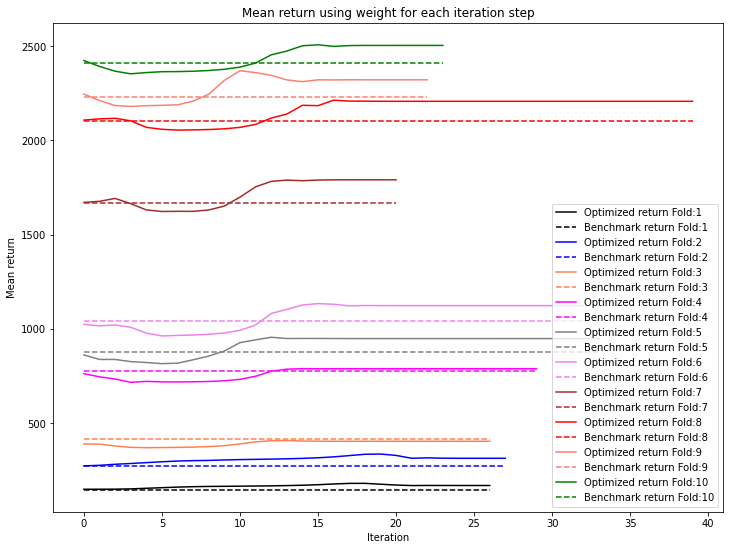

In [202]:
plt.figure(figsize=(12,9))
plt.title("Mean return using weight for each iteration step")
for fold, mean_r in enumerate(mean_r_fold):
    x = range(len(mean_r))
    plt.plot(x, mean_r, label=f'Optimized return Fold:{fold+1}', c=colors[fold])
    plt.plot(x, [benchmark_r_fold[fold]]*len(mean_r), label=f'Benchmark return Fold:{fold+1}', c=colors[fold], linestyle='dashed')
#     plt.plot(x, [eq_weighetd_r_fold[fold]]*len(mean_r), label=f'Equally weighted return Fold:{fold+1}', c=colors[fold], marker='.')
    plt.xlabel('Iteration')
    plt.ylabel('Mean return')
    plt.legend()
    plt.grid()
plt.show()

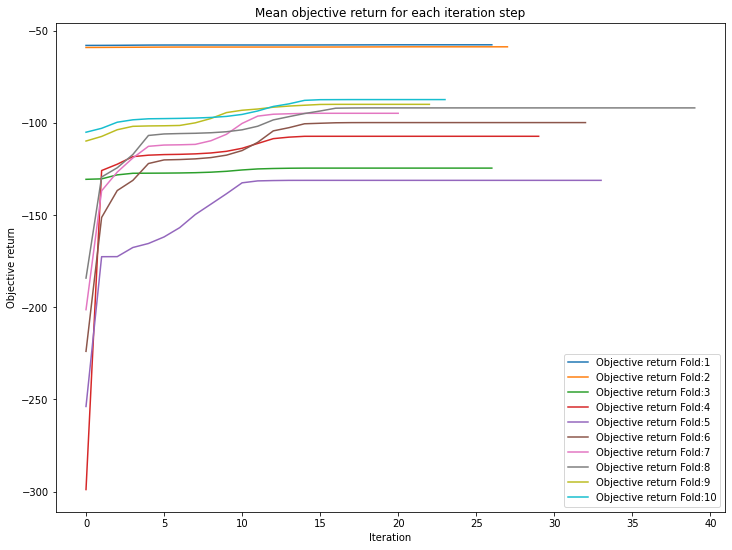

In [203]:
plt.figure(figsize=(12,9))
plt.title("Mean objective return for each iteration step")
for fold, mean_obj_r in enumerate(mean_obj_r_fold):
    x = range(len(mean_obj_r))
    plt.plot(x, mean_obj_r, label=f'Objective return Fold:{fold+1}')
    plt.xlabel('Iteration')
    plt.ylabel('Objective return')
    plt.legend()
    plt.grid()
plt.show()

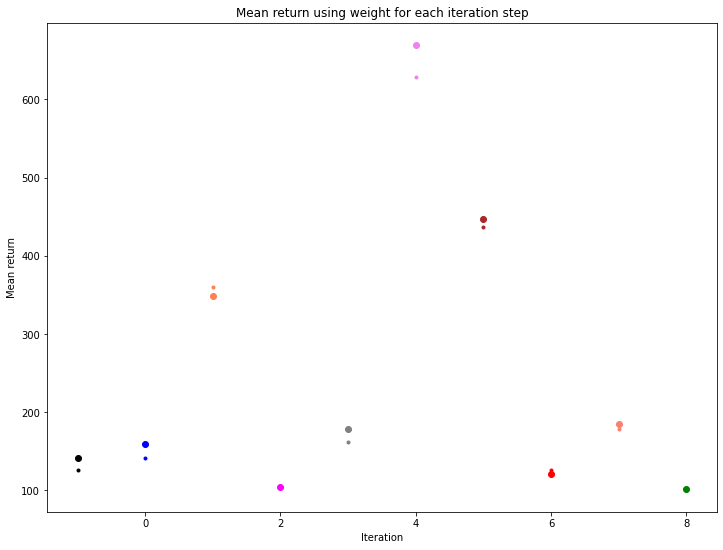

In [204]:
plt.figure(figsize=(12,9))
plt.title("Mean return using weight for each iteration step")
for fold, mean_test_r in enumerate(test_r_fold):
    x = range(fold-1, fold)
    plt.scatter(x, mean_test_r, label=f'Optimized test return Fold:{fold+1}', c=colors[fold])
    plt.scatter(x, benchmark_test_r_fold[fold], label=f'Benchmark test return Fold:{fold+1}', c=colors[fold], marker='.')
#     plt.plot(x, [eq_weighetd_r_fold[fold]]*len(mean_r), label=f'Equally weighted return Fold:{fold+1}', c=colors[fold], marker='.')
    plt.xlabel('Iteration')
    plt.ylabel('Mean return')
#     plt.legend()
    plt.grid()
plt.show()

### Mean theta over k-fold using all data comparison to benchmark

In [220]:
mean_theta = sum(theta_fold)/len(theta_fold)
mean_theta

array([-70.54723186,   1.22495446,   0.56366495])

In [222]:
mom = lreturn
me = mcap
btm = book_to_mkt_ratio
retrn = monthly_return

In [242]:
firm_characteristics, r, time, number_of_stocks = create_characteristics(me, mom, btm, retrn)
firm_characteristics.fillna(method='ffill', inplace=True)

Created firm characteristics matrix
Normalized firm characteristics


In [243]:
w_benchmark = np.empty(shape=(number_of_stocks, time))
epsilon=1e-5
for t in range(time):
    positive_returns = (r[:,t]-min(r[:,t]))+epsilon
    w_benchmark[:,t] = positive_returns/sum(positive_returns)

In [244]:
benchmark_mean_return = sum(sum(w_benchmark*r))
benchmark_mean_return

2511.058219101258

In [245]:
w = np.empty(shape=(number_of_stocks, time))
for i in range(number_of_stocks):
    firm_df = firm_characteristics[i].copy()
    firms_coeff = mean_theta.dot(firm_df.T)
    w[i] = w_benchmark[i] + (1/number_of_stocks)*firms_coeff

    
mean_r = sum(sum(w*r))
mean_r

2623.274012683434

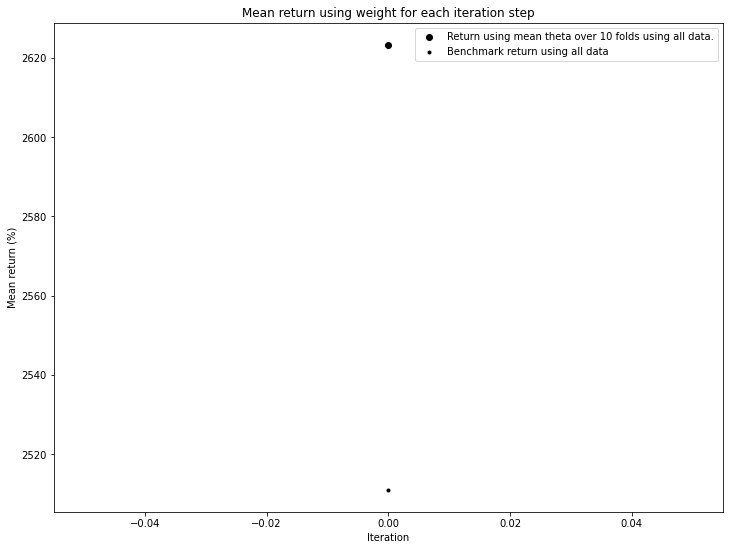

In [254]:
plt.figure(figsize=(12,9))
plt.title("Mean return using weight for each iteration step")

plt.xlabel('Iteration')
plt.ylabel('Mean return (%)')

x = range(0, 1)
plt.scatter(x, mean_r, c='black', label='Return using mean theta over 10 folds using all data.')
plt.scatter(x, benchmark_mean_return, c='black', marker='.', label='Benchmark return using all data')
plt.legend()
plt.show()